<a href="https://colab.research.google.com/github/mmistroni/OpenBB_Experiments/blob/main/OpenBBFinancialAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the OpenBB Platform in Google Colab

This notebook will install the OpenBB Platform, fetch some data and prepare it for display as a bar chart.

Sign up for a free account here: https://my.openbb.co

In [ ]:
# Install the OpenBB Platform with all available extensions.
# Messages indicating package version conflicts at the end of installation can be safely ignored.

!pip install openbb[all]

# There is also a nightly distribution available, openbb-nightly

In [ ]:
# Before running this cell, restart the runtime by selecting, "Restart runtime", from the "Runtime" menu.

# Import statements - for many scenarios, the only import needed will be `from openbb import obb`
from typing import Literal
from IPython.display import display
from IPython.display import clear_output
import ipywidgets as widgets
import pandas as pd
import pandas_ta as ta
from datetime import datetime , date
from plotly import graph_objects as go

from openbb import obb

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Extensions to add: seeking_alpha@1.1.1, finra@1.1.1, ecb@1.1.1, nasdaq@1.1.2, cboe@1.1.1, biztoc@1.1.1, government_us@1.1.1, openbb_charting@1.1.1, econometrics@1.1.1, stockgrid@1.1.1, quantitative@1.1.1, wsj@1.1.1, technical@1.1.2, alpha_vantage@1.1.1

Building...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

def get_openbb_keys():
  with open('gdrive/My Drive/passwords/openbb.keys') as f:
    return f.readlines()[0]

def get_benzinga_keys():
  with open('gdrive/My Drive/passwords/benzinga.keys') as f:
    return f.readlines()[0]

def get_intrinio_keys():
  with open('gdrive/My Drive/passwords/intrinio.keys') as f:
    return f.readlines()[0]

def getfmpkeys():
  with open('gdrive/My Drive/passwords/fmprep.keys') as f:
    return f.readlines()[0]


Mounted at /content/gdrive


In [ ]:
# Login to OpenBB Hub to retrieve stored API keys.
# https://my.openbb.co/app/platform/pat
# https://my.openbb.co/app/platform/api-keys

obb.account.login(pat=get_openbb_keys())

In [ ]:
obb.user.credentials.benzinga_api_key=get_benzinga_keys()
obb.user.credentials.intrinio_api_key=get_intrinio_keys()

In [ ]:
# Verify that the credentials from Hub were loaded successfully.


obb.user.preferences.output_type = "dataframe"
obb.user.credentials

Credentials

alpha_vantage_api_key: None
benzinga_api_key: **********
biztoc_api_key: None
fmp_api_key: **********
fred_api_key: **********
intrinio_api_key: **********
nasdaq_api_key: None
polygon_api_key: None
tiingo_token: None
tradingeconomics_api_key: None

### Defining Tickers for Analysis


In [ ]:
# Set the output preference, if desired. The examples below use Pandas DataFrames.
from datetime import timedelta
from dateutil.relativedelta import relativedelta
TICKER = 'DIS'
TICKER2 = '^GSPC' # S&P500
SECTOR_TICKER = 'XLY'
INDUSTRY_TICKER = 'XME'
startDate = date.today() - relativedelta(years=5)

### Return Comparison

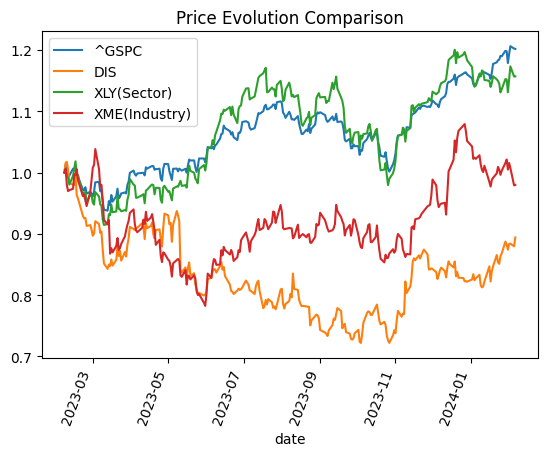

In [ ]:
obb.equity.price.historical(symbol = 'AAPL', provider='fmp')
import matplotlib.pyplot as plt
spy = obb.equity.price.historical(symbol = TICKER2, provider='fmp')[['close']].rename(columns={'close' : TICKER2})
dis = obb.equity.price.historical(symbol = TICKER, provider='fmp')[['close']].rename(columns={'close' : TICKER})
sector = obb.equity.price.historical(symbol = SECTOR_TICKER, provider='fmp')[['close']].rename(columns={'close' : SECTOR_TICKER})
industry = obb.equity.price.historical(symbol = INDUSTRY_TICKER, provider='fmp')[['close']].rename(columns={'close' : INDUSTRY_TICKER})

one = pd.merge(spy, dis, left_index=True, right_index=True)
two = pd.merge(one, sector,left_index=True, right_index=True)
result = pd.merge(two, industry,left_index=True, right_index=True)
histpriceconcat = result/result.iloc[0]


for i, col in enumerate([TICKER2, TICKER, SECTOR_TICKER, INDUSTRY_TICKER]):
    histpriceconcat[col].plot()

plt.title('Price Evolution Comparison')
plt.xticks(rotation=70)

legendCols = [TICKER2, TICKER, f'{SECTOR_TICKER}(Sector)', f'{INDUSTRY_TICKER}(Industry)']

plt.legend(legendCols)
#plt.savefig('foo1.png', bbox_inches='tight')
#
plt.show()


### Overview

In [ ]:
obb.equity.fundamental.overview(symbol=TICKER)

,0,1
0,symbol,DIS
1,price,98.1897
2,beta,1.384
3,vol_avg,12801524
4,mkt_cap,180108384813
5,last_div,0.6
6,range,78.73-118.18
7,changes,1.5397
8,company_name,The Walt Disney Company
9,currency,USD


### Stock Peers

In [ ]:
import os
import requests

def get_peers(ticker):
    apiKey = getfmpkeys()
    baseUrl = f'https://financialmodelingprep.com/api/v4/stock_peers?symbol={ticker}&apikey={apiKey}'
    return requests.get(baseUrl).json()[0].get('peersList', [])

full_tickers = obb.equity.compare.peers(symbol=TICKER)[1].values.tolist()[0]
full_tickers

['ROKU', 'AMC', 'PARA', 'WBD', 'NFLX', 'PARAA', 'APE']

### Generate comparative measures


### Ratios Overview

In [ ]:
liq_ratios = ['current_ratio', 'quick_ratio', 'operating_cash_flow_per_share',  'days_of_sales_outstanding' ]
solvency_ratios = ['interest_coverage', 'debt_ratio',  'debt_equity_ratio'] #missing shareholder equity ratio
profitability_ratios = ['gross_profit_margin', 'operating_profit_margin',
                        #revenuePerShare
                        'pretax_profit_margin',
                        'net_profit_margin',
                        #Cash flow margin
                        'return_on_assets',
                        'return_on_equity',
                        'return_on_capital_employed',
                         #'price_to_sales_ratio'
                         ]

In [ ]:
annual_ratios = obb.equity.fundamental.ratios(symbol=TICKER, period="annual", limit=5)
quarterly_ratios = obb.equity.fundamental.ratios(symbol=TICKER, period="quarter", limit=12)
quarterly_ratios['key'] = quarterly_ratios.apply(lambda row: f"{row['fiscal_period']}_{row['fiscal_year']}", axis=1)
# Income statement. we need this for trajectory of fundamentals
annual_income = obb.equity.fundamental.income(symbol=TICKER, period="annual", limit=5)
quarterly_income = obb.equity.fundamental.income(symbol=TICKER, period="quarter", limit=12)
quarterly_income['key'] = quarterly_ratios.apply(lambda row: f"{row['fiscal_period']}_{row['fiscal_year']}", axis=1)



In [ ]:
annual_liquidity = annual_ratios[liq_ratios + ['fiscal_year'] ].set_index('fiscal_year')
annual_solvency = annual_ratios[solvency_ratios + ['fiscal_year'] ].set_index('fiscal_year')
annual_profitability = annual_ratios[profitability_ratios + ['fiscal_year'] ].set_index('fiscal_year')
quarterly_liquidity = quarterly_ratios[liq_ratios + ['key'] ].set_index('key')
quarterly_solvency = quarterly_ratios[solvency_ratios + ['key'] ].set_index('key')
quarterly_profitability = quarterly_ratios[profitability_ratios + ['key'] ].set_index('key')

annual_income = annual_income.set_index('fiscal_year')
quarterly_income = quarterly_income.set_index('key')


### Liquidity Annnually and Quarterly

<Axes: title={'center': 'Liquidity Ratios qtr'}, xlabel='key'>

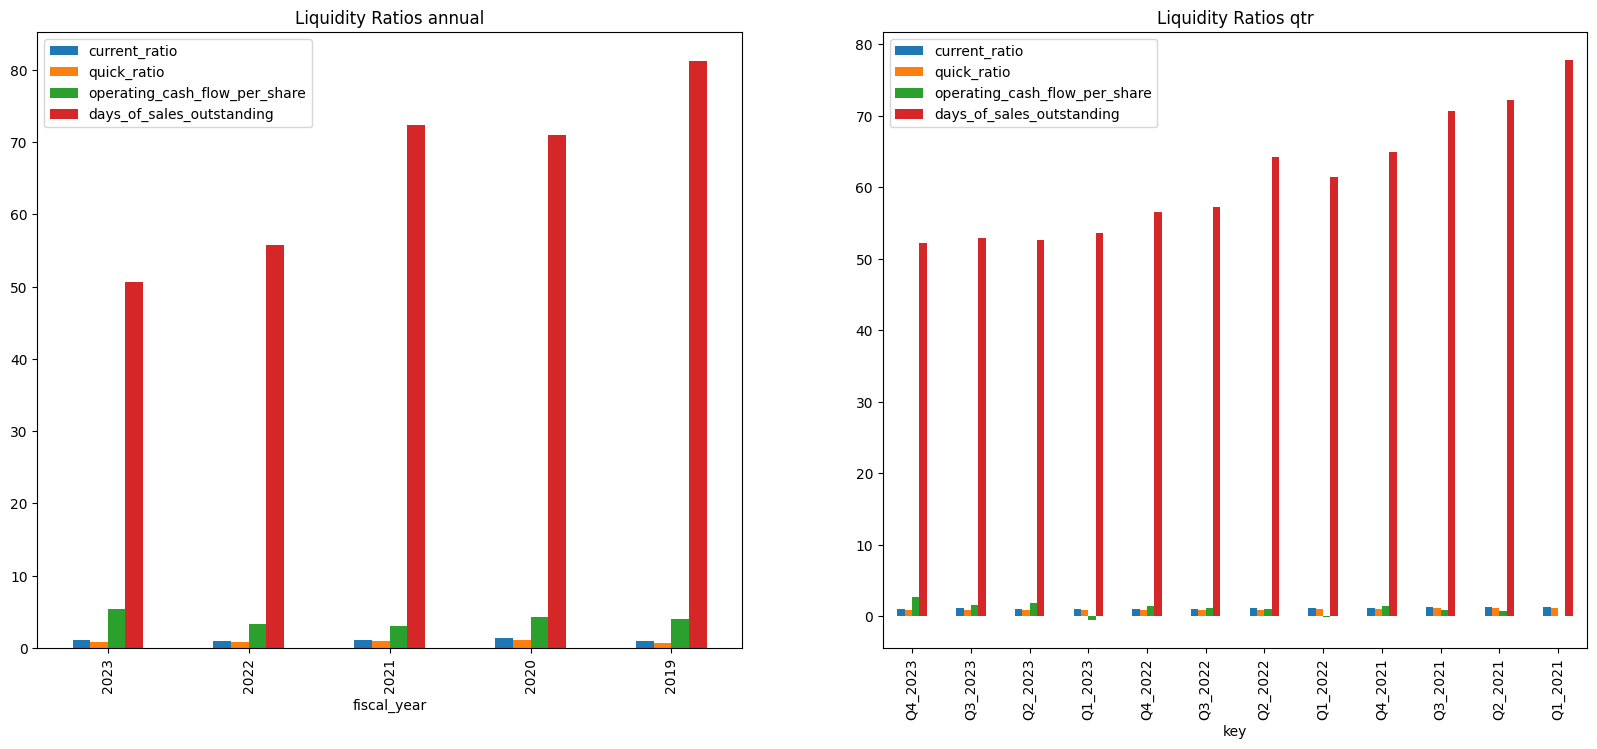

In [ ]:
#annual_liquidity
import matplotlib.pyplot as plt

#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
annual_liquidity.apply(pd.to_numeric).plot.bar(figsize=(10,8), title='Liquidity Ratios annual', ax=axes[0])
quarterly_liquidity.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Liquidity Ratios qtr', ax=axes[1])

### Profitability

<Axes: title={'center': 'Profitability Ratios qtr'}, xlabel='key'>

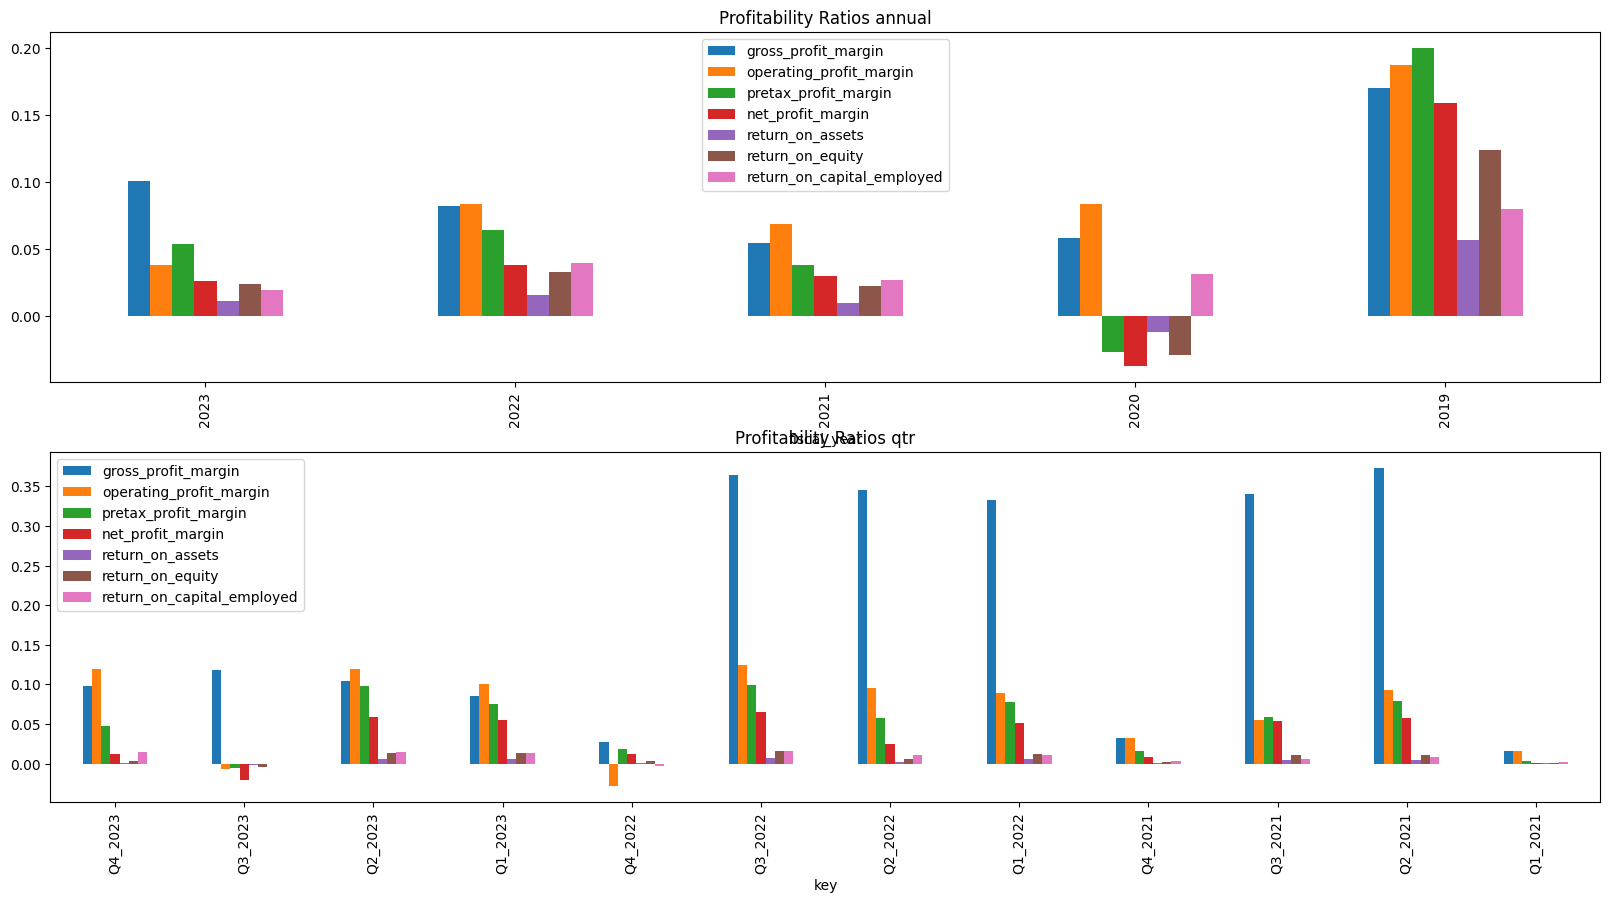

In [ ]:
#annual_liquidity
import matplotlib.pyplot as plt

#define subplot layout
fig, axes = plt.subplots(nrows=2, ncols=1)
annual_profitability.apply(pd.to_numeric).plot.bar(figsize=(20, 10),title='Profitability Ratios annual', ax=axes[0])
quarterly_profitability.apply(pd.to_numeric).plot.bar(figsize=(20,10), title='Profitability Ratios qtr', ax=axes[1])

### Solvency

<Axes: title={'center': 'Solvency Ratios qtr'}, xlabel='key'>

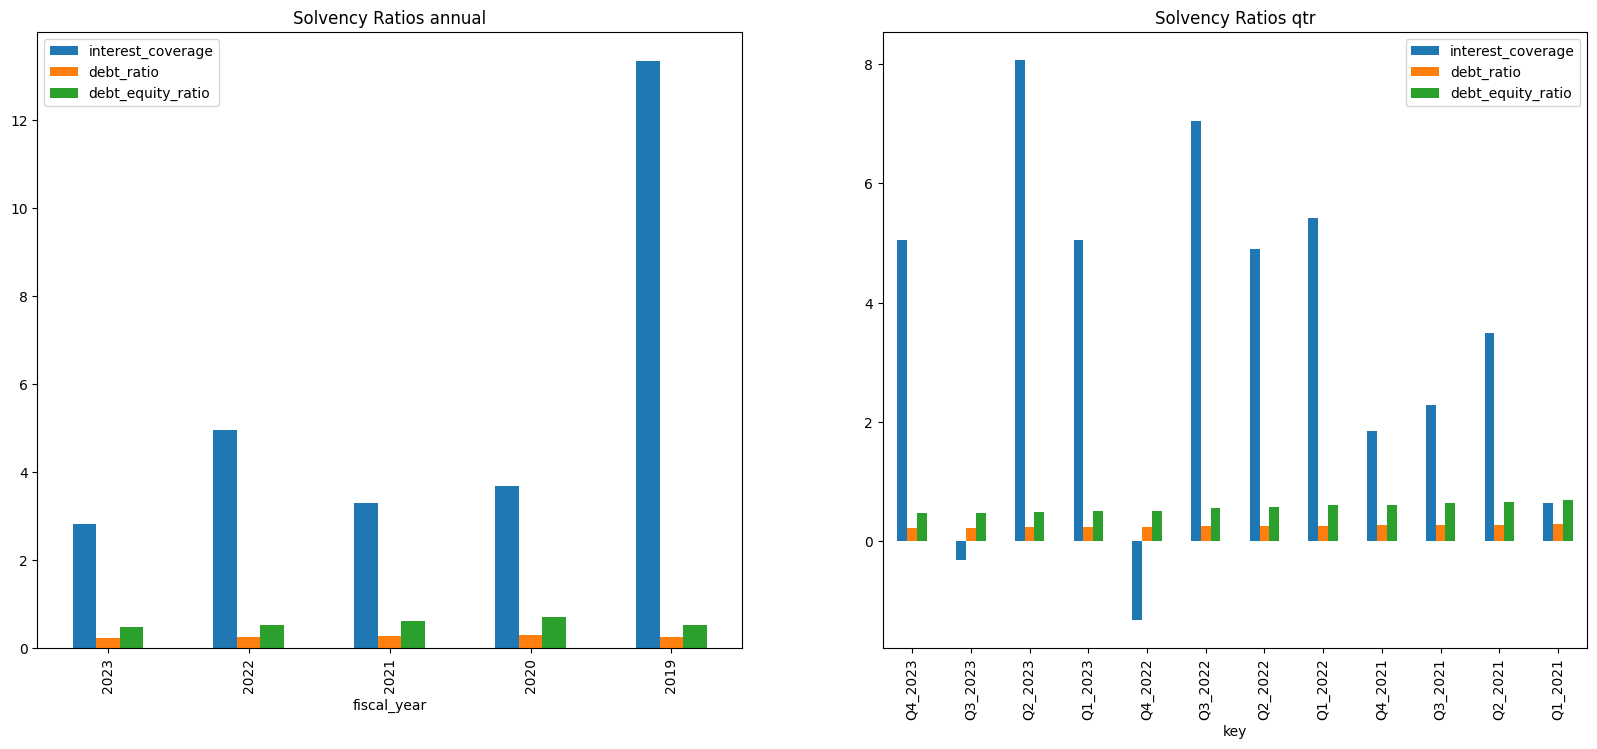

In [ ]:
import matplotlib.pyplot as plt

#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
annual_solvency.apply(pd.to_numeric).plot.bar(figsize=(10,8), title='Solvency Ratios annual', ax=axes[0])
quarterly_solvency.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Solvency Ratios qtr', ax=axes[1])

### Now we will resort to the old analysis with Management, Profitability etc that we were used to do in colab

## Now Using other measures before checking financial statements in details

* Gross Profit Margin: Indicates how efficiently a company produces goods or

services by measuring the difference between revenue and the cost of goods sold (COGS).
* Net Profit Margin: Measures a company’s overall profitability by calculating the percentage of net income relative to revenue.
* Return on Assets (ROA): Assesses a company’s ability to generate profits from its assets, calculated by dividing net income by total assets.
* Return on Equity (ROE): Evaluates a company’s ability to generate returns for its shareholders by dividing net income by shareholders’ equity.
* Operating Profit Margin: Shows a company’s operating efficiency by measuring operating income as a percentage of revenue.



## TODO. follow https://colab.research.google.com/drive/1ZdGLqEfAXfiseahjIwxlRXgQbPg3-5Ol#scrollTo=LArvBJ9Qs9a2
COMPARE Across years

- check asset value (total assets, total liabilities, outstading shares, NAV
- compar across years priceearningration, priceearningtogrowthratio, earningyield
- net income, operating cf, capital expenditure, free cf, cashand cash equiv, year of cash


We are looking for htis

<ul>
    <li><b>Staying power</b>: You want to make sure a company has the financial resources to endure a downturn and come out on the other side.<li>
    <li><b>The trajectory of the fundamentals</b>: Because a stock price, over time, is connected to a company’s revenue and earnings, fundamental analysts try to see improving trends in the company’s revenue and profit. Trend spotting will be discussed at more length in Chapter 17.</li>
    <li><b>Evidence of skilled management</b>: A management team with experience navigating through the ups and downs of a business may give the fundamental analyst more confidence in the company’s future. Skilled managers can protect their company’s business from competition with strong brands, service, or quality.</li>
    <li><b>Valuation</b>: Even if a company is performing poorly, the stock can still be a good investment if the bad news is already reflected in the price. Fundamental analysts spend a great deal of their time comparing a company’s current stock price to its real value, based on what they think it’s worth. You discovered how to use the price-to-earnings ratio, or P-E, as a valuation tool in Chapter 8. In this chapter you’ll find out about the earnings yield. Fundamental analysts also look for good values using the discounted cash-flow model, explored in Chapter 11.</li>
    <li><b>Dividend payments</b>: These seemingly small cash payments can quickly add up and become a significant consideration for a fundamental analyst. Fundamental analysts also use these dividends as a way to measure the attractiveness of some stocks, as will be discussed at the end of this chapter.</li>
    </ul>
In addition, we might want to look at this. (Check what we already fetch from our superperformers loader)

<ol>
    <li>Financial Health:
        <ol>
<li>Revenue Growth Rate: Ideally, a company should have a positive revenue growth rate of at least 5% per year.</li>
<li>Profit Margin: A healthy profit margin varies by industry, but a company with a profit margin of at least 10% is generally considered financially healthy.</li>
<li>Debt-to-Equity Ratio: A ratio of less than 1 indicates that a company is financed more by equity than debt, which is generally considered financially healthy.</li>
<li>Free Cash Flow: A positive free cash flow indicates that a company is generating cash from its operations and is able to invest in growth opportunities.</li>
        </ol>
    </li>
 <li>Competitive Advantage:
    <ol>
<li>Market Share: A company with a market share of at least 20% is generally considered to have a strong competitive advantage in its industry.</li>
<li>Return on Equity: A healthy return on equity varies by industry, but a company with a return on equity of at least 15% is generally considered to have a strong competitive advantage.</li>
<li>Price-to-Earnings Ratio: A company with a price-to-earnings ratio that is lower than its peers may indicate that the company is undervalued and has a strong competitive advantage.</li>
<li>Research and Development (R&D) Spending: A company that invests at least 5% of its revenue in R&D is generally considered to be investing in innovation and maintaining its competitive advantage.</li>
     </ol>
  </li>
  <li>Management Quality:
    <ol>
<li>CEO Tenure: Ideally, a CEO should have been leading the company for at least 3–5 years to demonstrate a track record of success.</li>
<li>Executive Compensation: Executive compensation varies by industry, but excessive compensation may indicate poor management quality.</li>
<li>Employee Turnover Rate: A low employee turnover rate indicates that employees are satisfied and that the management team is effective at retaining talent.</li>
<li>Return on Assets: A healthy return on assets varies by industry, but a company with a return on assets of at least 5% is generally considered to have effective management.  </li>
      </ol>
    </li>
</ol>
    
    

### Fundamental Measures

In [ ]:
skilled_management_measures = ['return_on_assets', 'return_on_equity', 'return_on_capital_employed']
staying_power_measures = idxs = ['return_on_capital_employed', 'current_ratio', 'debt_equity_ratio', 'interest_coverage', 'cash_per_share']
valuation_measures = ['price_earnings_to_growth_ratio', 'price_earnings_ratio']
profitability_measures = ["date", "revenue", "costOfRevenues", "operatingExpenses", # will need to probably get them from net income
              "otherExpenses", "netIncome", "ebitda", "interestExpense", "incomeTaxExpense",
              "operatingIncome"]
financial_rations_measures = ['return_on_equity', 'return_on_capital_employed',"receivablesTurnover",
              "inventoryTurnover", "payablesTurnover", "debt_equity_ratio",
              "current_ratio", "quick_ratio", "cash_ratio", "interest_coverage",
              "priceToBookRatio", "dividendYield", "dividendPayoutRatio", "priceEarningsRatio",
              "priceEarningsToGrowthRatio", "cashPerShare"]

trajectory_of_fundamentals = ['revenue', 'diluted_earnings_per_share', 'consolidated_net_income']
cashflow_measures = ['symbol', 'netIncome', "operatingCashFlow", "capitalExpenditure", "freeCashFlow", "ebtida"]
trend_measures = ['operatingIncome', 'revenues', 'eps', 'dividend']

# Find net asset value

In [ ]:
ratios = obb.equity.fundamental.ratios(symbol=TICKER, period="annual", limit=5)


### Staying Power (annual)

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


<Axes: title={'center': 'Traj of Fundamentals'}, xlabel='fiscal_year'>

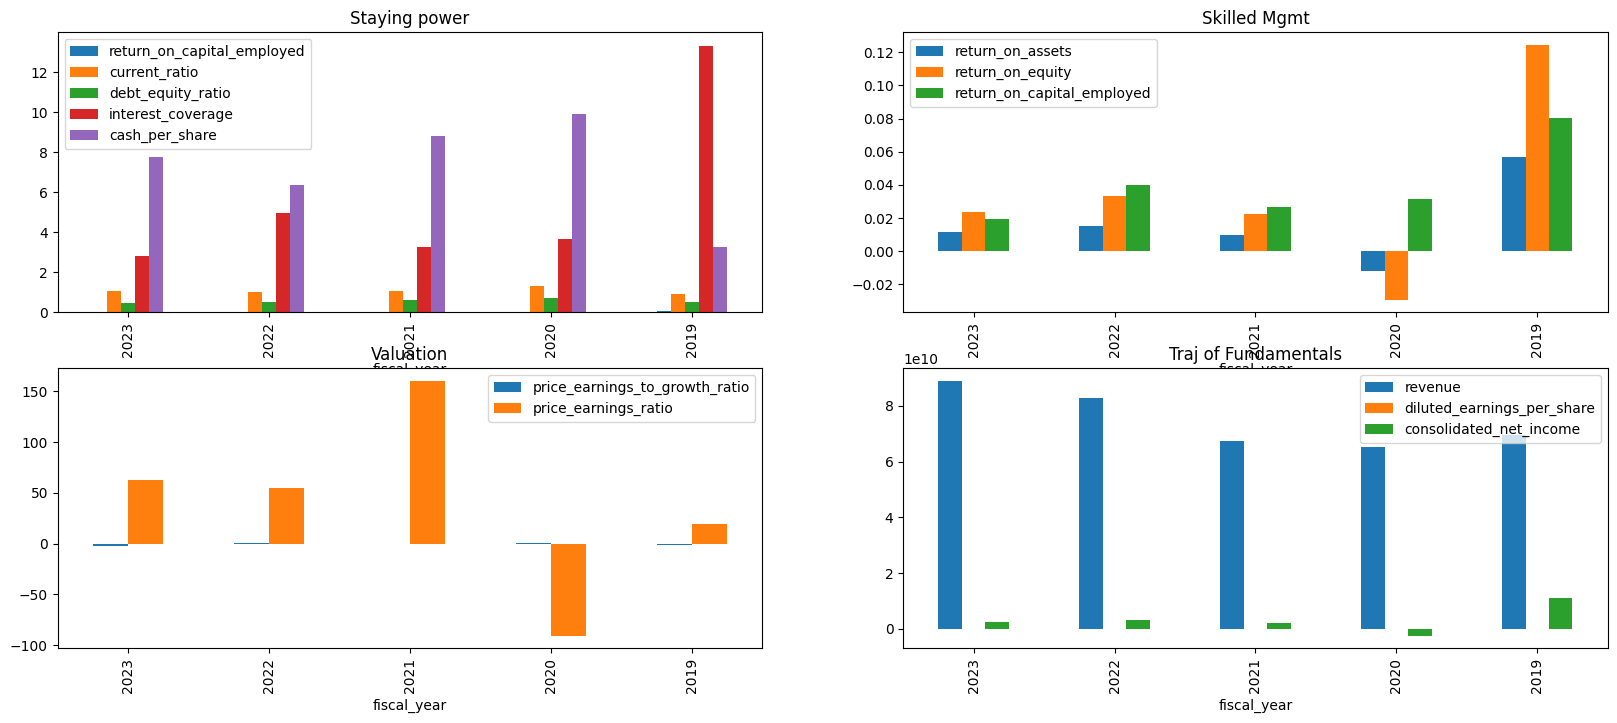

In [ ]:
fig, axes = plt.subplots(2, 2)
print(axes)
staying_power_measures = ['fiscal_year'] + ['return_on_capital_employed', 'current_ratio', 'debt_equity_ratio', 'interest_coverage', 'cash_per_share']
skilled_mgmt_measures = ['fiscal_year'] + skilled_management_measures
valuation_measures = ['fiscal_year'] + valuation_measures
staying_power = annual_ratios[staying_power_measures].set_index('fiscal_year')
skilled_mgmt = annual_ratios[skilled_mgmt_measures].set_index('fiscal_year')
valuation = annual_ratios[valuation_measures].set_index('fiscal_year')
traj_fundamentals = annual_income[trajectory_of_fundamentals]
staying_power.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Staying power', ax=axes[0,0])
skilled_mgmt.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Skilled Mgmt', ax=axes[0,1])
valuation.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Valuation', ax=axes[1,0])
traj_fundamentals.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Traj of Fundamentals', ax=axes[1,1])

### Quarterly

[[<Axes: title={'center': 'Staying power'}, xlabel='fiscal_year'>
  <Axes: title={'center': 'Skilled Mgmt'}, xlabel='fiscal_year'>]
 [<Axes: title={'center': 'Valuation'}, xlabel='fiscal_year'>
  <Axes: title={'center': 'Traj of Fundamentals'}, xlabel='fiscal_year'>]]


<Axes: title={'center': 'Traj of Fundamentals'}, xlabel='key'>

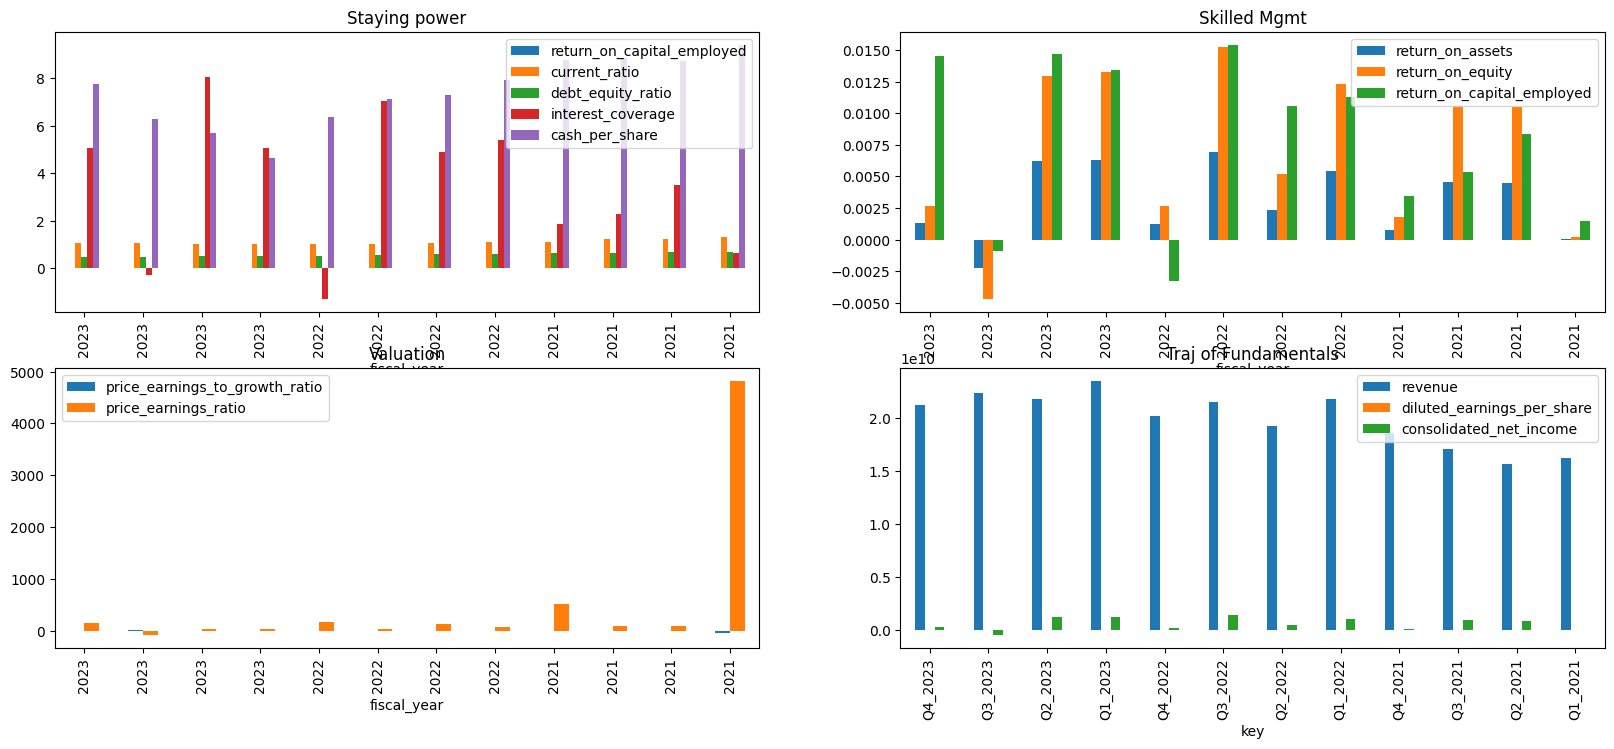

In [ ]:
fig_qtr, qtr_axes = plt.subplots(2, 2)
print(axes)

staying_power_qtr = quarterly_ratios[staying_power_measures].set_index('fiscal_year')
skilled_mgmt_qtr = quarterly_ratios[skilled_mgmt_measures].set_index('fiscal_year')
valuation_qtr = quarterly_ratios[valuation_measures].set_index('fiscal_year')
traj_fundamentals_qtr = quarterly_income[trajectory_of_fundamentals]
staying_power_qtr.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Staying power', ax=qtr_axes[0,0])
skilled_mgmt_qtr.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Skilled Mgmt', ax=qtr_axes[0,1])
valuation_qtr.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Valuation', ax=qtr_axes[1,0])
traj_fundamentals_qtr.apply(pd.to_numeric).plot.bar(figsize=(20,8), title='Traj of Fundamentals', ax=qtr_axes[1,1])

###Dividends Over Time

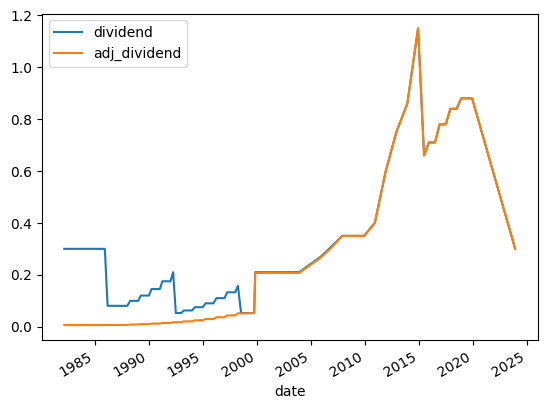

In [ ]:
df = obb.equity.fundamental.dividends(TICKER)
df[df.index > startDate.strftime('%Y-%m-%d')]
if df.shape[0] > 1:
    df.plot()

### Estimates

In [ ]:
obb.equity.estimates.consensus(symbol=TICKER)

,0,1
0,symbol,DIS
1,target_high,263.0
2,target_low,50.0
3,target_consensus,149.47
4,target_median,140.5


### Discounted cashflow

In [ ]:
ov_df = obb.equity.fundamental.overview(symbol=TICKER)
ov_df[ov_df[0].isin(['dcf', 'dcf_diff'])]

,0,1
27,dcf_diff,81.52724
28,dcf,16.672761


### Splits

In [ ]:
obb.equity.fundamental.historical_splits(TICKER)

,label,numerator,denominator
date,,,
1962-12-18,"December 18, 62",103.0,100.0
1967-11-16,"November 16, 67",2.0,1.0
1970-11-24,"November 24, 70",102.0,100.0
1971-02-02,"February 02, 71",2.0,1.0
1971-03-01,"March 01, 71",2.0,1.0
1971-11-24,"November 24, 71",102.0,100.0
1973-01-16,"January 16, 73",2.0,1.0
1973-11-27,"November 27, 73",102.0,100.0
1974-11-29,"November 29, 74",102.0,100.0


### Financial Statement Growth

In [ ]:
obb.equity.fundamental.balance_growth(symbol=TICKER, limit=10)

,symbol,period,growth_cash_and_cash_equivalents,growth_short_term_investments,growth_cash_and_short_term_investments,growth_net_receivables,growth_inventory,growth_other_current_assets,growth_total_current_assets,growth_property_plant_equipment_net,...,growth_common_stock,growth_retained_earnings,growth_accumulated_other_comprehensive_income_loss,growth_othertotal_stockholders_equity,growth_total_stockholders_equity,growth_total_liabilities_and_stockholders_equity,growth_total_investments,growth_total_debt,growth_net_debt,calendarYear
date,,,,,,,,,,,,,,,,,,,,,
2014-09-30,DIS,FY,-0.129738,0.0,-0.129738,0.122721,0.058507,0.323967,0.075625,0.042538,...,0.025748,0.125131,-0.657961,-0.188740,-0.010368,0.036250,-0.053703,0.038634,0.102539,2014
2015-09-30,DIS,FY,0.247881,0.0,0.247881,0.025185,-0.001906,0.200999,0.104244,0.079162,...,0.023935,0.098522,-0.230183,-0.148264,-0.009631,0.047466,-0.019659,0.168194,0.144321,2015
2016-09-30,DIS,FY,0.079878,0.0,0.079878,0.130440,-0.115213,-0.279626,0.012412,0.086183,...,0.020984,0.119604,-0.643536,-0.158864,-0.028299,0.043671,0.619372,0.163475,0.190786,2016
2017-09-30,DIS,FY,-0.128633,0.0,-0.128633,-0.047656,-0.012230,-0.151515,-0.063480,0.038649,...,0.010848,0.098626,0.113345,-0.170155,-0.045071,0.040811,-0.251869,0.253892,0.367224,2017
2018-09-30,DIS,FY,0.033109,0.0,0.033109,0.081200,0.013838,0.079932,0.058909,0.039921,...,0.014649,0.138735,0.122166,-0.055881,0.180516,0.029325,-0.094628,-0.174647,-0.213876,2018
2019-09-28,DIS,FY,0.305542,0.0,0.305542,0.658560,0.184626,0.541732,0.671560,0.069838,...,0.465701,-0.486036,-1.136584,0.986580,0.822258,0.967423,0.112108,1.250934,1.485530,2019
2020-10-03,DIS,FY,2.306386,0.0,2.306386,-0.179123,-0.040024,-0.106231,0.253413,0.015030,...,0.010945,-0.098343,-0.257670,0.000000,-0.059565,0.038998,0.210608,0.247776,-0.020545,2020
2021-10-02,DIS,FY,-0.109133,0.0,-0.109133,0.051857,-0.159191,-0.066286,-0.045219,0.017021,...,0.017873,0.055174,0.226148,0.000000,0.059462,0.010221,0.008199,-0.072013,-0.055681,2021
2022-10-01,DIS,FY,-0.272198,0.0,-0.272198,-0.053490,0.308790,0.467564,-0.135455,0.029794,...,0.016711,0.079324,0.360404,0.000000,0.072894,0.000108,-0.182211,-0.110962,-0.044035,2022


In [ ]:
obb.equity.fundamental.income_growth(symbol=TICKER, limit=10)

,symbol,period,growth_revenue,growth_cost_of_revenue,growth_gross_profit,growth_gross_profit_ratio,growth_research_and_development_expenses,growth_general_and_administrative_expenses,growth_selling_and_marketing_expenses,growth_other_expenses,...,growth_income_before_tax,growth_income_before_tax_ratio,growth_income_tax_expense,growth_net_income,growth_net_income_ratio,growth_eps,growth_eps_diluted,growth_weighted_average_shs_out,growth_weighted_average_shs_out_dil,calendarYear
date,,,,,,,,,,,,,,,,,,,,,
2014-09-30,DIS,FY,0.083746,0.047259,0.221164,0.126799,0.0,0.0,0.0,0.550725,...,0.272973,0.174605,0.421582,0.222458,0.127993,0.260234,0.260355,-0.029018,-0.029785,2014
2015-09-30,DIS,FY,0.074816,0.052800,0.145927,0.066161,0.0,0.0,0.0,76.935484,...,0.132451,0.053623,0.182461,0.117451,0.039667,0.148492,0.150235,-0.026437,-0.028425,2015
2016-09-30,DIS,FY,0.060364,0.051808,0.085753,0.023944,0.0,0.0,0.0,0.073492,...,0.072108,0.011076,0.012360,0.120377,0.056597,0.163636,0.169388,-0.038371,-0.040960,2016
2017-09-30,DIS,FY,-0.008898,-0.000242,-0.033779,-0.025105,0.0,0.0,0.0,-0.969133,...,-0.072639,-0.064314,-0.129185,-0.043765,-0.035181,-0.005208,-0.006981,-0.037446,-0.037218,2017
2018-09-30,DIS,FY,0.077933,0.080773,0.069487,-0.007835,0.0,0.0,0.0,6.705128,...,0.068248,-0.008985,-0.623926,0.402895,0.301468,0.465969,0.469244,-0.044005,-0.044994,2018
2019-09-28,DIS,FY,0.170542,0.294235,-0.201254,-0.317627,0.0,0.0,0.0,5.921797,...,-0.053296,-0.191226,0.822610,-0.122559,-0.250398,-0.204762,-0.205742,0.104736,0.105508,2019
2020-10-03,DIS,FY,-0.060112,0.067136,-0.679858,-0.659383,0.0,0.0,0.0,0.284856,...,-1.125000,-1.132995,-0.769383,-1.220916,-1.235045,-1.202096,-1.203313,0.091787,0.085234,2020
2021-10-02,DIS,FY,0.031045,0.035150,-0.035582,-0.064622,0.0,0.0,0.0,-0.043779,...,2.469306,2.425064,-0.964235,1.816953,1.792354,1.814815,1.807407,0.004425,0.011062,2021
2022-10-01,DIS,FY,0.227002,0.191236,0.850232,0.507930,0.0,0.0,0.0,0.010174,...,1.063647,0.681862,68.280000,0.576441,0.284791,0.572727,0.577982,0.003304,-0.000547,2022


In [ ]:
obb.equity.fundamental.cash_growth(symbol=TICKER, limit=10)

,symbol,period,growth_net_income,growth_depreciation_and_amortization,growth_deferred_income_tax,growth_stock_based_compensation,growth_change_in_working_capital,growth_accounts_receivables,growth_inventory,growth_accounts_payables,...,growth_other_financing_activities,growth_net_cash_used_provided_by_financing_activities,growth_effect_of_forex_changes_on_cash,growth_net_change_in_cash,growth_cash_at_end_of_period,growth_cash_at_beginning_of_period,growth_operating_cash_flow,growth_capital_expenditure,growth_free_cash_flow,calendarYear
date,,,,,,,,,,,,,,,,,,,,,
2014-09-30,DIS,FY,0.206148,0.043796,4.619565,0.014925,-23.888889,-2.520971,-2.588235,0.460490,...,0.246753,-0.592311,-12.055556,-1.937500,-0.129738,0.160614,0.034702,-0.184192,-0.028095,2014
2015-09-30,DIS,FY,0.105947,0.028846,-1.197292,0.004902,0.358414,0.310972,1.012346,-1.091418,...,1.118056,0.178241,-0.285106,2.662745,0.247881,-0.129738,0.115440,-0.288130,0.027052,2015
2016-09-30,DIS,FY,0.105965,0.073492,12.901961,-0.041463,-0.264817,0.425842,185.000000,1.816327,...,-1.619672,-0.267864,0.592715,-0.597877,0.079878,0.247881,0.211202,-0.119109,0.270319,2016
2017-09-30,DIS,FY,-0.043309,0.100910,-0.724876,-0.073791,-0.181456,-0.616482,-1.026882,-10.200000,...,-1.976190,-0.281505,1.252033,-3.041056,-0.118438,0.115015,-0.065844,0.240939,0.033175,2017
2018-09-30,DIS,FY,0.395046,0.082315,-5.709581,0.079670,-0.147679,-1.127451,-2.400000,1.638587,...,0.664000,0.012948,-1.806452,1.130747,0.022392,-0.146218,0.158146,-0.232404,0.127294,2018
2019-09-28,DIS,FY,-0.164779,0.381601,1.074380,0.809160,-3.548529,1.205069,-12.117647,-0.187234,...,108.634921,0.876739,-2.920000,13.285714,0.312876,0.022392,-0.537880,-0.092049,-0.824008,2019
2020-10-03,DIS,FY,-1.223770,0.284856,-4.350427,-0.261603,0.895732,3.013483,1.062780,-13.005236,...,-0.583296,8.779817,1.387755,8.614615,2.291292,0.312876,0.153194,0.175144,1.078613,2020
2021-10-02,DIS,FY,2.038493,-0.043779,-2.165816,0.142857,4.401550,-1.104143,17.000000,2.051025,...,-1.038221,-1.517099,-0.210526,-1.156092,-0.108667,2.291292,-0.269231,0.110393,-0.446885,2021
2022-10-01,DIS,FY,0.401025,0.010174,1.161160,0.628333,-0.777575,4.252688,-2.666667,-0.600000,...,-0.314815,-0.081186,-21.100000,-1.225525,-0.271324,-0.108667,0.079576,-0.381498,-0.463550,2022


### Historical Market Cap Last 5 yrs

<Axes: xlabel='date'>

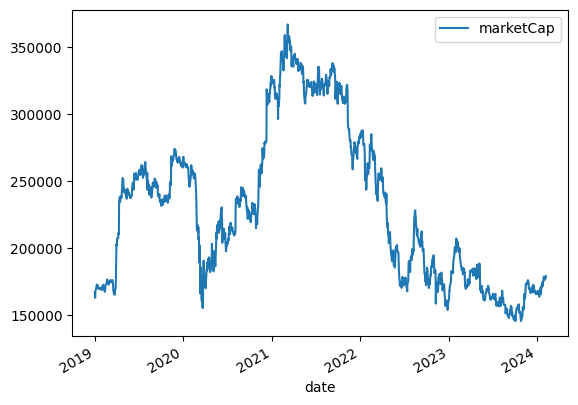

In [ ]:
end_date = date.today()
start_date = date(end_date.year-5, 1, 1)
fmp_url =  f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{TICKER}?from={start_date.strftime('%Y-%m-%d')}&to={end_date.strftime('%Y-%m-%d')}&apikey={getfmpkeys()}"
data = requests.get(fmp_url).json()

df = pd.DataFrame(data)[['date', 'marketCap']]
df['date'] = pd.to_datetime(df.date)
df['marketCap'] = df.marketCap / 1000000

df = df.set_index('date')
#df.plot(figsize=(15,4))
df.plot()





### Insider Tradings

In [ ]:
obb.equity.ownership.insider_trading(symbol=TICKER, limit=500)

,symbol,company_cik,filing_date,transaction_date,owner_cik,owner_name,owner_title,transaction_type,acquisition_or_disposition,security_type,securities_owned,securities_transacted,transaction_price,filing_url,form_type
0,DIS,1744489,2024-02-05 16:18:19,2024-02-05,1182328,GORMAN JAMES P,director:,,,,0.0,0.0,0.00,https://www.sec.gov/Archives/edgar/data/174448...,3
1,DIS,1744489,2024-01-18 18:50:25,2024-01-17,1969984,Coleman Sonia L,officer: Sr. EVP and Chief HR Officer,M-Exempt,D,Restricted Stock Unit,5774.0,1154.0,0.00,https://www.sec.gov/Archives/edgar/data/174448...,4
2,DIS,1744489,2024-01-18 18:50:25,2024-01-17,1969984,Coleman Sonia L,officer: Sr. EVP and Chief HR Officer,M-Exempt,A,Disney Common Stock,3016.0,1154.0,0.00,https://www.sec.gov/Archives/edgar/data/174448...,4
3,DIS,1744489,2024-01-18 18:50:25,2024-01-17,1969984,Coleman Sonia L,officer: Sr. EVP and Chief HR Officer,F-InKind,D,Disney Common Stock,2542.0,474.0,91.93,https://www.sec.gov/Archives/edgar/data/174448...,4
4,DIS,1744489,2024-01-18 18:50:14,2024-01-17,1211698,WOODFORD BRENT,"officer: EVP, Control, Fin Plan & Tax",M-Exempt,A,Disney Common Stock,34768.0,1178.0,0.00,https://www.sec.gov/Archives/edgar/data/174448...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,DIS,1744489,2021-10-04 20:08:31,2021-09-30,1492154,Barra Mary T,director,A-Award,A,Disney Common Stock,9934.6,446.8,176.26,https://www.sec.gov/Archives/edgar/data/174448...,4
496,DIS,1744489,2021-10-04 20:08:08,2021-09-30,1224543,LAGOMASINO MARIA ELENA,director,A-Award,A,Disney Common Stock,18740.8,489.4,176.26,https://www.sec.gov/Archives/edgar/data/174448...,4
497,DIS,1744489,2021-10-04 20:07:43,2021-09-30,1520943,deSouza Francis A,director,A-Award,A,Disney Common Stock,7618.4,446.1,176.26,https://www.sec.gov/Archives/edgar/data/174448...,4
498,DIS,1744489,2021-10-04 20:07:12,2021-09-30,1749971,MCDONALD CALVIN,director,A-Award,A,Disney Common Stock,619.9,446.8,176.26,https://www.sec.gov/Archives/edgar/data/174448...,4


In [ ]:
obb.equity.discovery.filings(limit=100, form_type='13F')

,symbol,cik,title,form_type,link,done
date,,,,,,
2023-08-14 07:52:15,BCDRF,0000891478,"13F-HR/A - Banco Santander, S.A. (0000891478) ...",13F-HR/A,https://www.sec.gov/Archives/edgar/data/891478...,True
2023-08-14 07:52:15,SAN,0000891478,"13F-HR/A - Banco Santander, S.A. (0000891478) ...",13F-HR/A,https://www.sec.gov/Archives/edgar/data/891478...,True
2023-08-14 07:56:29,SAN,0000891478,"13F-HR/A - Banco Santander, S.A. (0000891478) ...",13F-HR/A,https://www.sec.gov/Archives/edgar/data/891478...,True
2023-08-14 07:56:29,BCDRF,0000891478,"13F-HR/A - Banco Santander, S.A. (0000891478) ...",13F-HR/A,https://www.sec.gov/Archives/edgar/data/891478...,True
2023-09-21 09:45:59,BCS,0000312069,13F-HR/A - BARCLAYS PLC (0000312069) (Filer),13F-HR/A,https://www.sec.gov/Archives/edgar/data/312069...,True
2023-09-21 09:45:59,BCLYF,0000312069,13F-HR/A - BARCLAYS PLC (0000312069) (Filer),13F-HR/A,https://www.sec.gov/Archives/edgar/data/312069...,True
2023-09-21 13:42:35,JEF,0000096223,13F-HR/A - Jefferies Financial Group Inc. (000...,13F-HR/A,https://www.sec.gov/Archives/edgar/data/96223/...,True
2023-09-25 17:34:10,BAMI,0001001085,13F-HR/A - BROOKFIELD Corp /ON/ (0001001085) (...,13F-HR/A,https://www.sec.gov/Archives/edgar/data/100108...,True
2023-09-25 17:34:10,BN,0001001085,13F-HR/A - BROOKFIELD Corp /ON/ (0001001085) (...,13F-HR/A,https://www.sec.gov/Archives/edgar/data/100108...,True


### OBV

<Axes: >

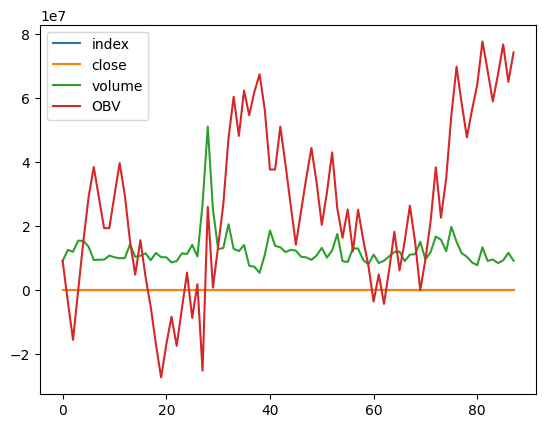

In [ ]:
from openbb import obb
stock_data = obb.equity.price.historical(symbol=TICKER, start_date="2023-10-01", provider="fmp")[['close', 'volume']]
stock_data
obb.technical.obv(data=stock_data, offset=0).plot()

### Ownership

In [ ]:
import requests
import re
df  =obb.equity.fundamental.overview(symbol=TICKER)
ticker_exchange = df[df[0].isin(['exchange_short_name'])][1].values[0]
base_url = f'https://www.marketbeat.com/stocks/{ticker_exchange}/{TICKER.upper()}/institutional-ownership/'
print(base_url)
str1 = requests.get(
    ).text
string_pattern = r"Institutional Ownership Percentage.*[\d]+\.[\d]+%<\/div>"
# compile string pattern to re.Pattern object
regex_pattern = re.compile(string_pattern)
res = regex_pattern.findall(str1)[0]
float(res[res.find('strong>') + 7: res.rfind('%')])


https://www.marketbeat.com/stocks/NYSE/DIS/institutional-ownership/


TypeError: get() missing 1 required positional argument: 'url'

In [ ]:
obb.equity.ownership.institutional(symbol="AAPL", provider='yfinance')